# Estimating hotspot(s) emission and rotational axis from visibilties. 

Notes:
Inner most stable circular orbit (ISCO), for spin=0 with r_g=2 this is at 3M \
Overleaf notes: https://www.overleaf.com/project/60ff0ece5aa4f90d07f2a417

In [1]:
import sys
sys.path.append('../bhnerf')

import os

import jax
from jax import random
from jax import numpy as jnp
import jax.scipy.ndimage as jnd
import scipy.ndimage as nd

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import xarray as xr
import flax
from flax.training import train_state
from flax.training import checkpoints
import optax
import numpy as np
import matplotlib.pyplot as plt

import utils, emission_utils, visualization, network_utils, observation_utils
from network_utils import shard

import ehtim as eh
import ehtim.const_def as ehc
from tensorboardX import SummaryWriter
from datetime import datetime
from tqdm.notebook import tqdm
import ipyvolume as ipv
from ipywidgets import interact
import ipywidgets as widgets

import mediapy as media

# from jax.config import config
# config.update("jax_debug_nans", True)
%load_ext autoreload
%autoreload 2

2021-10-29 01:11:26.496916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8072sq4t because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to eht-imaging! v 1.2.2 



In [2]:
sensor = xr.load_dataset('../sensors/a0.00_th1.57_ngeo100_npix4096.nc')
sensor = sensor.where(sensor.r < 5)
r_min = sensor.r.min().data   # Minimum supervision radius
sensor = sensor.fillna(0.0)

In [3]:
phi = 0.0                # azimuth angle (ccw from x-axis)
theta = np.pi/3          # zenith angle (pi/2 = equatorial plane)
rot_axis = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])

orbit_radius = 3.5
std = .4 * np.ones_like(orbit_radius)

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)
    
checkpoint_path = 'checkpoints/bgtests/ngEHT_pratul/checkpoint_2000'

In [4]:
# Perspective camera functions

def normalize(x):
    """Normalization helper function."""
    return x / np.linalg.norm(x)

def viewmatrix(lookdir, up, position):
    """Construct lookat view matrix."""
    vec2 = normalize(lookdir)
    vec0 = normalize(np.cross(up, vec2))
    vec1 = normalize(np.cross(vec2, vec0))
    m = np.stack([vec0, vec1, vec2, position], axis=1)
    return m

def generate_hemispherical_orbit(radius, n_frames=120):
    """Calculates a render path which orbits around the z-axis."""
    # Assume that z-axis points up towards approximate camera hemisphere
    render_poses = []

    up = np.array([0., 0., 1.])
    for theta in np.linspace(0., 2. * np.pi, n_frames):
        camorigin = radius * np.array(
            [np.cos(theta), np.sin(theta), 0.])
        render_poses.append(viewmatrix(camorigin, up, camorigin))

    render_poses = np.stack(render_poses, axis=0)
    return render_poses

def generate_elevated_orbit(radius, height, n_frames=120):
    """Calculates a render path which orbits around the z-axis."""
    # Assume that z-axis points up towards approximate camera hemisphere
    render_poses = []
    
    orbit_radius = np.sqrt(radius**2 - height**2)

    up = np.array([0., 0., 1.])
    for theta in np.linspace(0., 2. * np.pi, n_frames):
        camorigin = np.array(
            [orbit_radius * np.cos(theta), orbit_radius * np.sin(theta), height])
        render_poses.append(viewmatrix(camorigin, up, camorigin))

    render_poses = np.stack(render_poses, axis=0)
    return render_poses

def generate_rays(camtoworlds, width, height, focal):
    """Generating rays for all images."""
    x, y = np.meshgrid(  # pylint: disable=unbalanced-tuple-unpacking
        np.arange(width, dtype=np.float32),  # X-Axis (columns)
        np.arange(height, dtype=np.float32),  # Y-Axis (rows)
        indexing='xy')
    camera_dirs = np.stack(
        [(x - width * 0.5 + 0.5) / focal,
         -(y - height * 0.5 + 0.5) / focal, -np.ones_like(x)],
        axis=-1)
    directions = ((camera_dirs[None, ..., None, :] *
                   camtoworlds[:, None, None, :3, :3]).sum(axis=-1))
    origins = np.broadcast_to(camtoworlds[:, None, None, :3, -1],
                              directions.shape)

    return origins, directions

def sample_along_rays(rays_o, rays_d, near, far, num_samples):
    t_vals = jnp.linspace(near, far, num_samples)
    pts = rays_o[:, :, :, None, :] + t_vals[None, None, None, :, None] * rays_d[:, :, :, None, :]
    return pts

def draw_cube(emission, pts):
    facewidth = 10.
    linewidth = 0.15
#     linecolor = jnp.array([1000.0, 1000.0, 1000.0])
    linecolor = jnp.array([0.0, 0.0, 0.0, 1000.0])
    vertices = jnp.array([[-facewidth/2., -facewidth/2., -facewidth/2.],
                        [facewidth/2., -facewidth/2., -facewidth/2.],
                        [-facewidth/2., facewidth/2., -facewidth/2.],
                        [facewidth/2., facewidth/2., -facewidth/2.],
                        [-facewidth/2., -facewidth/2., facewidth/2.],
                        [facewidth/2., -facewidth/2., facewidth/2.],
                        [-facewidth/2., facewidth/2., facewidth/2.],
                        [facewidth/2., facewidth/2., facewidth/2.]])
    dirs = jnp.array([[-1., 0., 0.],
                      [1., 0., 0.],
                      [0., -1., 0.],
                      [0., 1., 0.],
                      [0., 0., -1.],
                      [0., 0., 1.]])
        
    cm = plt.get_cmap('hot')
    emission_cm = cm(emission)
    emission_cm = jnp.clip(emission_cm - 0.05, 0.0, 1.0)
    
    emission_cm = jnp.concatenate([emission_cm[..., :3], (emission[..., None] / jnp.amax(emission))], axis=-1)
    
#     emission = jnp.where(jnp.less(jnp.broadcast_to(emission[..., 0, None], emission.shape), 0.1), 
#                          jnp.zeros_like(emission), emission)

    for i in range(vertices.shape[0]):

        for j in range(dirs.shape[0]):
            # Draw line segments from each vertex
            line_seg_pts = vertices[i, None, :] + jnp.linspace(0.0, facewidth, 64)[:, None] * dirs[j, None, :]

            for k in range(line_seg_pts.shape[0]):
                dists = jnp.linalg.norm(pts - jnp.broadcast_to(line_seg_pts[k, None, None, None, :], pts.shape), axis=-1)
                # out = jnp.where(jnp.less_equal(dists, linewidth),
                #                 lineval * jnp.exp(-1. * dists), out)
                emission_cm += linecolor[None, None, None, :] * jnp.exp(-1. * dists / linewidth ** 2)[..., None]
    
    out = jnp.where(jnp.greater(jnp.broadcast_to(jnp.amax(jnp.abs(pts), axis=-1, keepdims=True), 
                                                 emission_cm.shape), 
                                facewidth/2. + linewidth), 
                    jnp.zeros_like(emission_cm), emission_cm)
        
    return out

In [5]:
nt = 64
nx = 64
ny = 64
nz = 64

x_res_vis = 128
y_res_vis = 128
z_res_vis = 128

hparams = {
    'num_iters': 50000,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'lr_axis': 1e-1,
    'posenc_deg': 3,
    'batchsize': 1,
    'r_min': r_min
}

# Training / testing coordinates
train_coords = network_utils.get_input_coords(sensor, t_array=np.linspace(0, 1, nt), batch='t')
t, x, y, z, d = train_coords.values()
t = np.linspace(0, 1, nt)

# Emission visualization inputs
t_res_vis = 1
emission_extent = [-5, 5, -5, 5, -5, 5]
t_vis, x_vis, y_vis, z_vis  = np.meshgrid(0, np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                          np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                          np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                          indexing='ij')

d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization
uv = np.zeros((1,171,2))
test_vis = np.zeros((1,171))

# Model setup and initialization
rng = jax.random.PRNGKey(1)
predictor = network_utils.PREDICT_EMISSION_AND_MLP_ROTAXIS_3D_FROM_VIS_W_BG_PRATUL(posenc_deg=hparams['posenc_deg'])
params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, 0, 1)['params']

def flattened_traversal(fn):
    def mask(data):
        flat = flax.traverse_util.flatten_dict(data)
        return flax.traverse_util.unflatten_dict({k: fn(k, v) for k, v in flat.items()})
    return mask

tx = optax.chain(
    optax.masked(optax.adam(learning_rate=hparams['lr_axis']),
                 mask=flattened_traversal(lambda path, _: path[-1] == 'axis')),
    optax.masked(optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters'])),
                 mask=flattened_traversal(lambda path, _: path[-1] != 'axis')),
)

state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy
state = checkpoints.restore_checkpoint(checkpoint_path, state)
state = flax.jax_utils.replicate(state)

eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, None, 0, 0, 0, None, 0, 0), static_broadcasted_argnums=(0))
rng = jax.random.PRNGKey(1)
rand_key = jax.random.split(rng, jax.local_device_count())

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:390: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:377: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


In [6]:
# poses = generate_hemispherical_orbit(25., n_frames=60)
poses = generate_elevated_orbit(25., 12.5, n_frames=60)
height = y_res_vis
width = x_res_vis
focal = .5 * width / jnp.tan(.5 * 0.7)
rays_o, rays_d = generate_rays(poses, width, height, focal)
pts = sample_along_rays(rays_o, rays_d, 15., 35., z_res_vis)

In [7]:
# Generate base hotspot emission
nt, nx, ny, nz = 64, 64, 64, 64
r_isco = 3.0 

phi = 0.0            # azimuth angle (ccw from x-axis)
theta = np.pi/3      # zenith angle (pi/2 = equatorial plane)
orbit_radius = 3.5 
std = .4 * np.ones_like(orbit_radius)
initial_frame = emission_utils.generate_hotspots_3d(nx, ny, nz, theta, phi, orbit_radius, std, r_isco, std_clip=np.inf)
rot_axis = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])

nspots = 4
initial_frame = emission_utils.generate_orbit_3d(initial_frame, nt, 1, rot_axis).isel(
    t=np.random.choice(range(0, nt, 5), size=nspots)).sum('t')

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)

emission = emission_utils.generate_orbit_3d(initial_frame, nt, velocity_field, rot_axis)

normalization_factor = 1.0
emission *= normalization_factor

print('rotation axis: {}'.format(rot_axis))

rotation axis: [ 0.5        0.        -0.8660254]


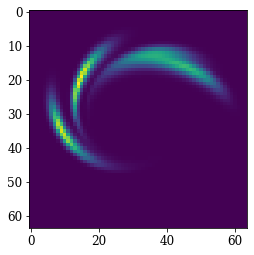

In [8]:
# Select fancy base frame
base_timestep = 20
initial_frame_fancy = emission.isel(t=base_timestep)

plt.figure()
plt.imshow(np.sum(initial_frame_fancy, axis=2))

In [9]:
# Generate fancy hotspot emission
nt, nx, ny, nz = 128, 64, 64, 64
nt_test = 128
r_isco = 3.0 

phi = 0.0            # azimuth angle (ccw from x-axis)
theta = np.pi/3      # zenith angle (pi/2 = equatorial plane)
orbit_radius = 3.5 
std = .4 * np.ones_like(orbit_radius)
initial_frame = emission_utils.generate_hotspots_3d(nx, ny, nz, theta, phi, orbit_radius, std, r_isco, std_clip=np.inf)
rot_axis = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])

nspots = 4
initial_frame = emission_utils.generate_orbit_3d(initial_frame, nt, 1, rot_axis).isel(
    t=np.random.choice(range(0, nt, 5), size=nspots)).sum('t')

# Add fancy base frame
initial_frame = initial_frame + initial_frame_fancy

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)

emission = emission_utils.generate_orbit_3d(initial_frame, nt, velocity_field, rot_axis)
emission_test = emission_utils.generate_orbit_3d(initial_frame, nt_test, velocity_field, rot_axis)

normalization_factor = 1.0
emission *= normalization_factor
emission_test *= normalization_factor

print('rotation axis: {}'.format(rot_axis))

rotation axis: [ 0.5        0.        -0.8660254]


In [87]:
def alpha_composite(emission, dists, pts, inside_halfwidth=4.5):
    emission = np.clip(emission, 0., 1.)
    color = emission[..., :-1] * dists[0, ..., None]
    alpha = emission[..., -1:] 
    
    inside = np.where(np.less(np.amax(np.abs(pts), axis=-1), inside_halfwidth), 
                      np.ones_like(pts[..., 0]),
                      np.zeros_like(pts[..., 0]))
    
    rendering = np.zeros_like(color[:, :, 0, :])
    acc = np.zeros_like(color[:, :, 0, 0])
    outside_acc = np.zeros_like(color[:, :, 0, 0])
    for i in range(alpha.shape[-2]):
        ind = alpha.shape[-2] - i - 1
        
        # if pixels inside cube, don't alpha composite
        rendering = rendering + inside[..., ind, None] * color[..., ind, :]
        
        # if pixels not inside cube, alpha composite      
        outside_alpha = alpha[..., ind, :] * (1. - inside[..., ind, None])
        rendering = rendering * (1. - outside_alpha) + color[..., ind, :] * outside_alpha 
        
        acc = alpha[..., ind, 0] + (1. - alpha[..., ind, 0]) * acc
        outside_acc = outside_alpha[..., 0] + (1. - outside_alpha[..., 0]) * outside_acc
        
    rendering += np.array([1., 1., 1.])[None, None, :] * (1. - acc[..., None])
    return rendering, outside_acc

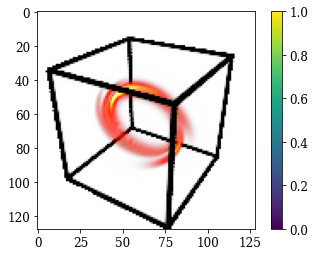

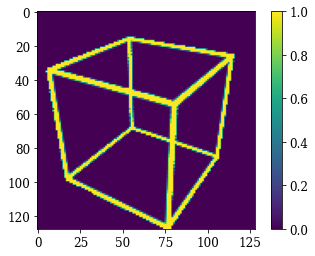

In [88]:
test, testacc = alpha_composite(emission_vis_cube, d_vis, pts[i, ...])

plt.figure()
plt.imshow(test)
plt.colorbar()

plt.figure()
plt.imshow(testacc)
plt.colorbar()

In [91]:
i = 20
t = 0.5
x_vis = pts[i:i+1, :, :, :, 0]
y_vis = pts[i:i+1, :, :, :, 1]
z_vis = pts[i:i+1, :, :, :, 2]
d_vis = jnp.linalg.norm(jnp.concatenate([jnp.diff(pts[i:i+1, ...], axis=3),
                                         jnp.zeros_like(pts[i:i+1, :, :, -1:])], 
                                         axis=3), axis=-1)

emission_gt = emission.sel(t=t, method='nearest').interp(x=xr.DataArray(x_vis[0]),
                                                         y=xr.DataArray(y_vis[0]),
                                                         z=xr.DataArray(z_vis[0])).fillna(0.0).data
emission_vis_cube = draw_cube(emission_gt, jnp.stack([x_vis[0], y_vis[0], z_vis[0]], axis=-1))

rendering, _ = alpha_composite(emission_vis_cube, d_vis, pts[i, ...])
rendering = jnp.clip(rendering, 0.0, 1.0)

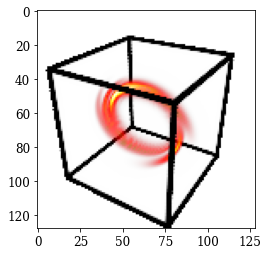

In [92]:
plt.figure()
plt.imshow(rendering)

plt.imsave('figures/vis_t0.5.pdf', rendering)

In [25]:
renderings = []

t = 0.

for i in range(0, 1):
    
    print('rendering pose:', i, 'at time:', t)
            
    x_vis = pts[i:i+1, :, :, :, 0]
    y_vis = pts[i:i+1, :, :, :, 1]
    z_vis = pts[i:i+1, :, :, :, 2]
    d_vis = jnp.linalg.norm(jnp.concatenate([jnp.diff(pts[i:i+1, ...], axis=3),
                                             jnp.zeros_like(pts[i:i+1, :, :, -1:])], 
                                            axis=3), axis=-1)
    
    t_vis = t * jnp.ones_like(x_vis)
    
    _, _, emission_vis, rendering_vis, axis_est, _ = eval_pstep(
        velocity_field, 0, 
        shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis), shard(uv), 
        100, 0, 1, 
        shard(test_vis), shard(jnp.zeros((1, y_res_vis, x_res_vis))), shard(jnp.ones_like(test_vis)), 
        jnp.zeros((y_res_vis, x_res_vis)),
        state, rand_key
    )
    axis_est = axis_est[0] / np.sqrt(np.dot(axis_est[0], axis_est[0]))
    emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
    emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 >= hparams['r_min']**2, emission_vis, jnp.zeros_like(emission_vis))
    emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 <= sensor.r.max().data**2, emission_vis, jnp.zeros_like(emission_vis))
    
    emission_vis_cube = draw_cube(emission_vis[0], jnp.stack([x_vis[0], y_vis[0], z_vis[0]], axis=-1))
    
    rendering = jnp.sum(emission_vis_cube * d_vis[0, ..., None], axis=-2)
    rendering = jnp.clip(rendering, 0.0, 1.0)
    renderings.append(rendering)

rendering pose: 0 at time: 0.0


(128, 128, 4)


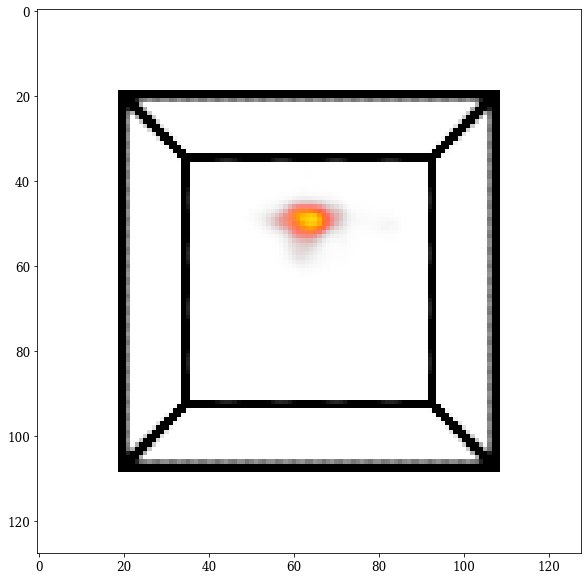

In [26]:
print(renderings[0].shape)

plt.figure(figsize=(10,10))
plt.imshow(renderings[0])

In [264]:
renderings = []

t = 0.

for i in range(0, pts.shape[0]):
    
    print('rendering pose:', i, 'at time:', t)
            
    x_vis = pts[i:i+1, :, :, :, 0]
    y_vis = pts[i:i+1, :, :, :, 1]
    z_vis = pts[i:i+1, :, :, :, 2]
    d_vis = jnp.linalg.norm(jnp.concatenate([jnp.diff(pts[i:i+1, ...], axis=3),
                                             jnp.zeros_like(pts[i:i+1, :, :, -1:])], 
                                            axis=3), axis=-1)
    
    t_vis = t * jnp.ones_like(x_vis)
    
    _, _, emission_vis, rendering_vis, axis_est, _ = eval_pstep(
        velocity_field, 0, 
        shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis), shard(uv), 
        100, 0, 1, 
        shard(test_vis), shard(jnp.zeros((1, y_res_vis, x_res_vis))), shard(jnp.ones_like(test_vis)), 
        jnp.zeros((y_res_vis, x_res_vis)),
        state, rand_key
    )
    axis_est = axis_est[0] / np.sqrt(np.dot(axis_est[0], axis_est[0]))
    emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
    emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 >= hparams['r_min']**2, emission_vis, jnp.zeros_like(emission_vis))
    emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 <= sensor.r.max().data**2, emission_vis, jnp.zeros_like(emission_vis))
    
    emission_vis_cube = draw_cube(emission_vis[0], jnp.stack([x_vis[0], y_vis[0], z_vis[0]], axis=-1))
    
    rendering = jnp.sum(emission_vis_cube * d_vis[0, ..., None], axis=-2)
    rendering = jnp.clip(rendering, 0.0, 1.0)
    renderings.append(rendering)

for t in jnp.linspace(0.0, 0.5, pts.shape[0]):
        
    print(i, t)
    
    x_vis = pts[i:i+1, :, :, :, 0]
    y_vis = pts[i:i+1, :, :, :, 1]
    z_vis = pts[i:i+1, :, :, :, 2]
    d_vis = jnp.linalg.norm(jnp.concatenate([jnp.diff(pts[i:i+1, ...], axis=3),
                                             jnp.zeros_like(pts[i:i+1, :, :, -1:])], 
                                            axis=3), axis=-1)
    
    t_vis = t * jnp.ones_like(x_vis)
    
    _, _, emission_vis, rendering_vis, axis_est, _ = eval_pstep(
        velocity_field, 0, 
        shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis), shard(uv), 
        100, 0, 1, 
        shard(test_vis), shard(jnp.zeros((1, y_res_vis, x_res_vis))), shard(jnp.ones_like(test_vis)), 
        jnp.zeros((y_res_vis, x_res_vis)),
        state, rand_key
    )
    axis_est = axis_est[0] / np.sqrt(np.dot(axis_est[0], axis_est[0]))
    emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
    emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 >= hparams['r_min']**2, emission_vis, jnp.zeros_like(emission_vis))
    emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 <= sensor.r.max().data**2, emission_vis, jnp.zeros_like(emission_vis))
    
    emission_vis_cube = draw_cube(emission_vis[0], jnp.stack([x_vis[0], y_vis[0], z_vis[0]], axis=-1))
    
    rendering = jnp.sum(emission_vis_cube * d_vis[0, ..., None], axis=-2)
    rendering = jnp.clip(rendering, 0.0, 1.0)
    renderings.append(rendering)
    
for i, t in enumerate(jnp.linspace(0.5, 1., pts.shape[0])):
    
    i += 30
        
    print(i, t)
    
    x_vis = pts[i:i+1, :, :, :, 0]
    y_vis = pts[i:i+1, :, :, :, 1]
    z_vis = pts[i:i+1, :, :, :, 2]
    d_vis = jnp.linalg.norm(jnp.concatenate([jnp.diff(pts[i:i+1, ...], axis=3),
                                             jnp.zeros_like(pts[i:i+1, :, :, -1:])], 
                                            axis=3), axis=-1)
    
    t_vis = t * jnp.ones_like(x_vis)
    
    _, _, emission_vis, rendering_vis, axis_est, _ = eval_pstep(
        velocity_field, 0, 
        shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis), shard(uv), 
        100, 0, 1, 
        shard(test_vis), shard(jnp.zeros((1, y_res_vis, x_res_vis))), shard(jnp.ones_like(test_vis)), 
        jnp.zeros((y_res_vis, x_res_vis)),
        state, rand_key
    )
    axis_est = axis_est[0] / np.sqrt(np.dot(axis_est[0], axis_est[0]))
    emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
    emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 >= hparams['r_min']**2, emission_vis, jnp.zeros_like(emission_vis))
    emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 <= sensor.r.max().data**2, emission_vis, jnp.zeros_like(emission_vis))
    
    emission_vis_cube = draw_cube(emission_vis[0], jnp.stack([x_vis[0], y_vis[0], z_vis[0]], axis=-1))
    
    rendering = jnp.sum(emission_vis_cube * d_vis[0, ..., None], axis=-2)
    rendering = jnp.clip(rendering, 0.0, 1.0)
    renderings.append(rendering)

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
29 0.0
29 0.01724138
29 0.03448276
29 0.051724136
29 0.06896552
29 0.0862069
29 0.10344827
29 0.12068965
29 0.13793103
29 0.15517241
29 0.1724138
29 0.18965517
29 0.20689654
29 0.22413793
29 0.2413793
29 0.25862068
29 0.27586207
29 0.29310346
29 0.31034482
29 0.3275862
29 0.3448276
29 0.36206895
29 0.37931034
29 0.39655173
29 0.4137931
29 0.43103448
29 0.44827586
29 0.46551725
29 0.4827586
29 0.5
30 0.5
31 0.51724136
32 0.5344828
33 0.55172414
34 0.5689655
35 0.5862069
36 0.6034483
37 0.62068963
38 0.637931
39 0.6551724
40 0.6724138
41 0.6896552
42 0.70689654
43 0.7241379
44 0.74137926
45 0.7586207
46 0.7758621
47 0.79310346
48 0.8103448
49 0.8275862
50 0.8448276
51 0.86206895
52 0.87931037
53 0.8965517
54 0.9137931
55 0.93103445
56 0.94827586
57 0.9655173
58 0.98275864
59 1.0


In [265]:
media.show_video(renderings, fps=30, codec='h264', width=400)

In [ ]:
%matplotlib widget
ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
ax.scatter(0,0,0, color='black', s=50)
ax.quiver(0,0,0,*rot_axis, length=0.05, linewidths=3,  label='true')
ax.quiver(0,0,0,*axis_est, length=0.05, linewidths=3, label='estimated', color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(fontsize=14)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'axis_est' is not defined